<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

import requests
import nltk
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup

### Datos
Utilizaremos como dataset el libro "El conde de montecristo" del autor Alejandro Dumas. Usando la pagina de https://www.textos.info

In [107]:
# se debe descargar el paquete 'punkt' de nltk
nltk.download('punkt')

# URL del libro
url = "https://www.textos.info/alejandro-dumas/el-conde-de-montecristo/ebook"

# Descargar el texto y filtrar informacion del libro
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
texto = soup.get_text()
texto_limpio = texto.replace("—", "")

# Dividir el texto en líneas
lineas = texto_limpio.splitlines()

inicio = next((i for i, linea in enumerate(lineas) if "El 24 de febrero de 1815" in linea), None)
fin = next((i for i, linea in enumerate(lineas) if "FIN" in linea), None)

# Eliminar líneas que no son relevantes ya que no tienen informacion del texto
lineas_relevantes = lineas[inicio:fin]

# Volver a unir las líneas en un solo texto
texto_relevante = '\n'.join(lineas_relevantes)

# Separar las oraciones
oraciones = sent_tokenize(texto_relevante, language='spanish')

# Guardar el dataset en un archivo
with open('dataset_oraciones.txt', 'w', encoding='utf-8') as f:
    for oracion in oraciones:
        oracion = oracion.replace('\xad', '')
        f.write(oracion + '\n')

print(f'Se han extraído {len(oraciones)} oraciones y se han guardado en "dataset_oraciones.txt".')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Se han extraído 28343 oraciones y se han guardado en "dataset_oraciones.txt".


In [109]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/dataset_oraciones.txt', sep='/n', header=None)
df.head()

<ipython-input-109-13817a156f10>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/dataset_oraciones.txt', sep='/n', header=None)


0
0  El 24 de febrero de 1815, el vigía de Nuestra ...
1  la señal de que se hallaba a la vista el berga...
2                     de Esmirna, Trieste y Nápoles.
3           Como suele hacerse en tales casos, salió
4  inmediatamente en su busca un práctico, que pa...

In [110]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 52573


### 1 - Preprocesamiento

In [123]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0], filters='¡!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n»«'))

In [124]:
# Demos un vistazo
sentence_tokens[340]

['hasta', 'la', 'vista', 'señor', 'morrel', 'y', 'gracias', 'por', 'todo']

### 2 - Crear los vectores (word2vec)

In [125]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [126]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=100,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [127]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [128]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 52573


In [129]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 6478


### 3 - Entrenar embeddings

In [130]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=40,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 2780528.75
Loss after epoch 1: 1907863.25
Loss after epoch 2: 1801781.0
Loss after epoch 3: 1770349.5
Loss after epoch 4: 1681108.5
Loss after epoch 5: 1655772.0
Loss after epoch 6: 1631685.0
Loss after epoch 7: 1614959.0
Loss after epoch 8: 1597359.0
Loss after epoch 9: 1531538.0
Loss after epoch 10: 1500586.0
Loss after epoch 11: 1485594.0
Loss after epoch 12: 1468134.0
Loss after epoch 13: 1455778.0
Loss after epoch 14: 1448572.0
Loss after epoch 15: 1437380.0
Loss after epoch 16: 1427790.0
Loss after epoch 17: 1415342.0
Loss after epoch 18: 1409964.0
Loss after epoch 19: 1403414.0
Loss after epoch 20: 1388854.0
Loss after epoch 21: 1334708.0
Loss after epoch 22: 1326688.0
Loss after epoch 23: 1318140.0
Loss after epoch 24: 1307552.0
Loss after epoch 25: 1302332.0
Loss after epoch 26: 1296312.0
Loss after epoch 27: 1287072.0
Loss after epoch 28: 1283356.0
Loss after epoch 29: 1276732.0
Loss after epoch 30: 1275556.0
Loss after epoch 31: 1265148.0
Loss after epoch

(11401691, 17312640)

### 4 - Ensayar

In [154]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["montecristo"], topn=15)

[('andrés', 0.6067432761192322),
 ('bertuccio', 0.5708314776420593),
 ('morcef', 0.5651816129684448),
 ('condesa', 0.5396329760551453),
 ('alberto', 0.5306165814399719),
 ('inglés', 0.5236360430717468),
 ('baronesa', 0.5229172110557556),
 ('dandré', 0.5198181867599487),
 ('salvieux', 0.5101431608200073),
 ('saludo', 0.5090684294700623),
 ('conteniendo', 0.5053369998931885),
 ('tímidamente', 0.5041931867599487),
 ('banquero', 0.5037457942962646),
 ('gendarme', 0.5005237460136414),
 ('conde', 0.4989330768585205)]

Observación
```
Es interesante ver que la palabra "montecristo" tiene semenjanza con:
-andres: es logico ya que es uno de las personas que ayuda al conde de montecristo en su venganza
-bertuccio: mayordomo de montecristo
-morcef: casa rival de montecristo y tambien de mercedes el amor de su vida
-condesa, baronesa, ingles: terminos del entorno en el que se desarrolla la novela
-alberto: amigo de montecristo e hijo de mercedes
-dandré: personaje que da el mensaje por el cual inculpan a edumundo dantes (despues montecristo)
-salvieux: otro personaje al inicio de la historia

Por lo que sin lugar a duda tienen el modelo logra aprender similitudes entre palabras tomando en
cuenta el contexto en el que aparecen.

```

In [177]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["venganza"], topn=10)

[('consuelo', 0.524246096611023),
 ('pasión', 0.49487584829330444),
 ('concebir', 0.4942984879016876),
 ('perseguidos', 0.4927222728729248),
 ('devolverle', 0.49134188890457153),
 ('revelar', 0.49100467562675476),
 ('compatriota', 0.4870558977127075),
 ('sospecho', 0.4814855456352234),
 ('toméis', 0.4812539517879486),
 ('fábula', 0.4789465367794037)]

Observación
```
Otras similitudes interesantes son las que tienen que ver con el término venganza
en la cual se centra la historia. los resultados ilustran cómo el modelo no solo
reconoce las palabras en un sentido aislado, sino que también considera su contexto
narrativo.
```

In [173]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["faria"], topn=10)

[('círculo', 0.06133437156677246),
 ('grandes', 0.04573517292737961),
 ('vuestra', 0.04054765775799751),
 ('pie', 0.03969405218958855),
 ('libertad', 0.03542211279273033),
 ('flor', 0.03371041268110275),
 ('formaban', 0.031024232506752014),
 ('muchas', 0.023679720237851143),
 ('parecía', 0.019940752536058426),
 ('espíritu', 0.019706975668668747)]

Observación
```
Faria fue un personaje que Edmundo (montecristo) conoció en la prision,
la 5ta palabra con menor similitud con Faria es libertad, lo cual obviamente es
contrario a prisión.
```



In [151]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["jacopo"])

KeyError: "Key 'jacopo' not present in vocabulary"

Observación
```
Da error ya que no existe la palabra jacopo, en realidad la palabra
correcta es jacobo (depende del idioma en el que esta la novela) que
fue un complice de montecristo
```

In [153]:
# el método `get_vector` permite obtener los vectores:
vector_montecristo = w2v_model.wv.get_vector("montecristo")
print(vector_montecristo)

[ 0.03788458 -0.4395992   0.02439278 -0.809121    0.2741481  -0.69216645
  0.78751916  0.37903956 -0.490869   -0.7080152   0.15927333 -0.44744515
 -0.36527842 -0.2590332  -0.4019639  -0.14677803 -0.19468693 -0.2743047
 -0.07628395  0.359186   -0.26609358  0.349627    0.13034762 -0.34789225
 -0.35390994 -0.41840193 -0.24759732  0.5579706   0.02177545  0.076623
  0.20083578  0.32695138 -0.38400024  0.35366163 -0.8110402   0.89396995
 -0.22403055  0.13238826 -0.2367984  -0.47103778  0.3055328  -0.38163382
  0.12811612 -0.10823295 -0.00634441  0.2598      0.00450949 -1.0610049
  0.01981336 -0.08950698  0.0580387   0.23199801 -0.21137181  0.2647603
 -0.30532748 -0.08471018  0.30120024  0.41342592  0.16773738 -0.35221857
  0.24536464  0.16822863 -0.41672903  0.26071858  0.30037507  0.7657049
 -0.32808897 -0.03181802 -0.692499   -0.41294497 -0.31019452 -0.17888668
 -0.8156754   0.27357027 -0.33639586  0.51102495 -0.41524538  0.58949935
 -0.4270646  -0.04325518 -0.18695298 -0.08731493 -0.75185

In [155]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_montecristo)

[('montecristo', 1.0000001192092896),
 ('andrés', 0.6067432761192322),
 ('bertuccio', 0.5708314776420593),
 ('morcef', 0.5651816129684448),
 ('condesa', 0.5396329164505005),
 ('alberto', 0.5306165814399719),
 ('inglés', 0.5236360430717468),
 ('baronesa', 0.5229172110557556),
 ('dandré', 0.519818127155304),
 ('salvieux', 0.5101431608200073)]

In [156]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["montecristo"], topn=10)

[('andrés', 0.6067432761192322),
 ('bertuccio', 0.5708314776420593),
 ('morcef', 0.5651816129684448),
 ('condesa', 0.5396329760551453),
 ('alberto', 0.5306165814399719),
 ('inglés', 0.5236360430717468),
 ('baronesa', 0.5229172110557556),
 ('dandré', 0.5198181867599487),
 ('salvieux', 0.5101431608200073),
 ('saludo', 0.5090684294700623)]

Observación
```
Al evaluar hacer la comparación con vectores y con el mismo término
(palabra) obtenemos los mismos resultados de similitudes lo cual es lo
esperado.
```

### 5 - Visualizar agrupación de vectores

In [157]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [158]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

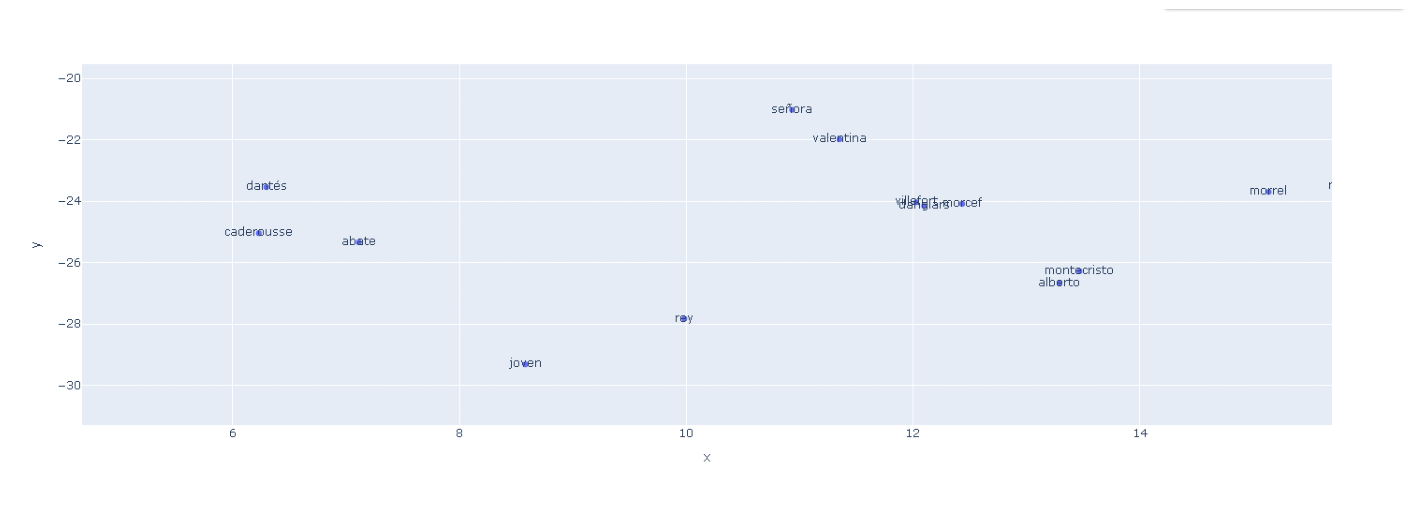

In [163]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar y mostrar la imagen
img = mpimg.imread('/content/2d.PNG')
plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

Observación
```
En la vista simplificada podemos observar varias cosas, tomando en cuenta
el recorte "2d.png", se observa:

-los términos dantés, caderousse y abate juntos lo cual tiene bastante sentido
caderousse es de los pocos amigos de (edmundo) dantés y abate es un sustantivo
para extranjero de la época, el cúal usa dantés cuando se proclama conde de
montecristo.

-los términos villefort, danglars y morcef estan especialmente agrupados los
ciañes son personajes importantes y los enemigos mas importantes de montecristo.

-los terminos anteriores y morrel estan cerca de montecristo, todos son personajes
importantes en la historia.
```

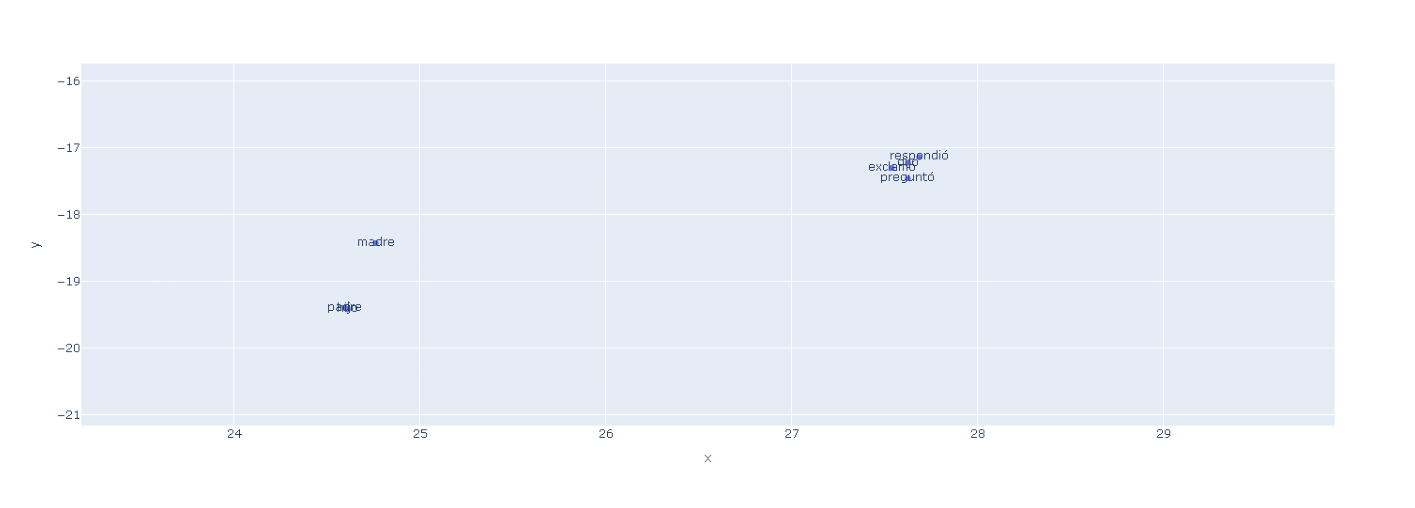

In [164]:
img = mpimg.imread('/content/2d b.PNG')
plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

Observación
```
En la vista simplificada, tomando en cuenta el recorte "2d b.png", se observa:

-los términos madre, hijo y padre están bastante cerca lo cual es logico.

-los términos respondió, preguntó y exclamó también están muy cerca y tiene
sentido gramaticalmente hablando, ya que son verbos en pasado y describen
acciones de comunicación
```

In [165]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

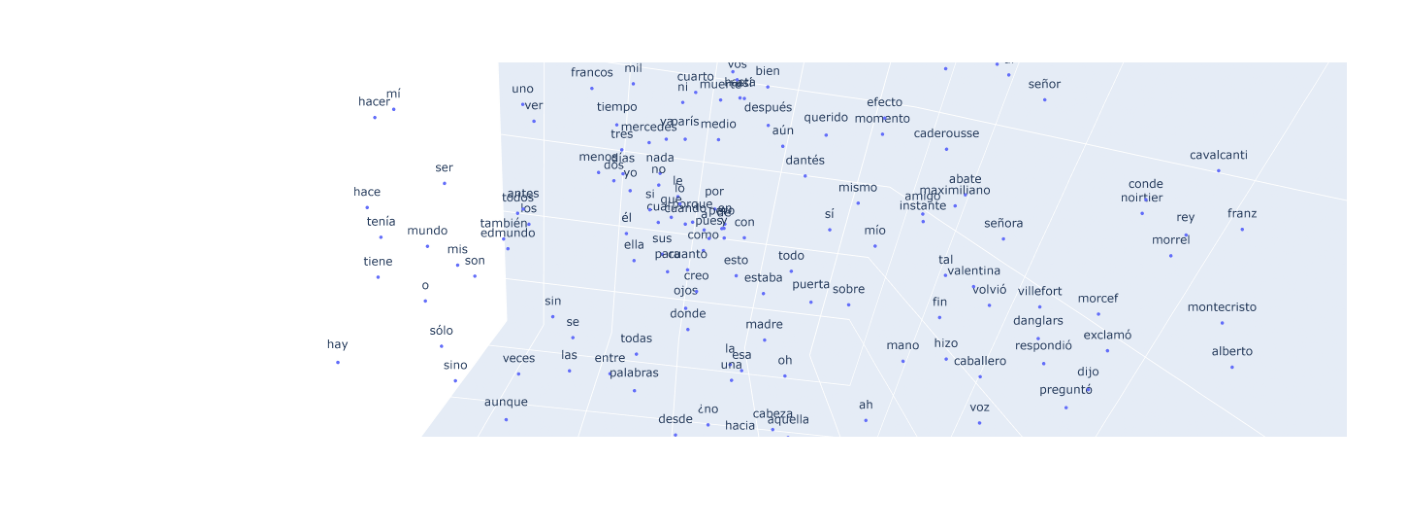

In [166]:
img = mpimg.imread('/content/3d.PNG')
plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

Observación
```
En la vista simplificada de 3D, tomando en cuenta el recorte "3d.png",
en la parte derecha se observa:

-los términos villefort, danglars, morcef, morrel, franz, noirtier,
cavalcanti, alberto; rodean a montecristo lo cual es logico ya que
todos son personajes importantes en la historia.

-los términos maximiliano, amigo, caderousse, mercedes rodean al término
dantés, también tiene sentido ya que tienen relevancia con respecto a
dantés.
```

Conclusiones
```
-El modelo es efectivo en la captura de similitudes semánticas entre las palabras del libro
-A través del entrenamiento, el modelo ha logrado identificar relaciones significativas
entre términos, lo que sugiere una comprensión del contexto en el que se utilizan.
-El modelo no solo reconoce las palabras en un sentido aislado, sino que también considera
su contexto narrativo.
-El modelo Wor2Vec demuestra ser una herramienta util para explorar la iterrelacion
de conceptos, complejidades semánticas y carácteristicas literarias.
```